# Description

Initial EDA for potential propensity score matching leakage.

# Imports

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from ipywidgets import interact

%matplotlib inline

# Load data

The `psm_leakage.csv` file was collected from Supplementary Figure 2 of Kidsios et al. "Can we trust observational studies using propensity scores in the critical care
literature? A systematic comparison with randomized clinical trials."

- [[Supplementary Material link](https://links.lww.com/CCM/B327)]

In [9]:
psm_leak = pd.read_csv("psm_leakage.csv")

# create a unique study id via index
psm_leak = psm_leak.reset_index()
psm_leak = psm_leak.rename({"index": "study_id"}, axis="columns")
psm_leak['study_id'] = psm_leak['study_id'].astype(str)
psm_leak.head()
psm_leak['ci_diff'] = psm_leak['upper_ci'] - psm_leak['lower_ci']

## Process data

In [10]:
(np.log(psm_leak['ci_diff']) + 1).describe()

count    89.000000
mean      1.027044
std       0.984797
min      -0.897120
25%       0.266031
50%       0.916618
75%       1.631272
max       3.060514
Name: ci_diff, dtype: float64

Text(0.5, 0, 'ps estimates')

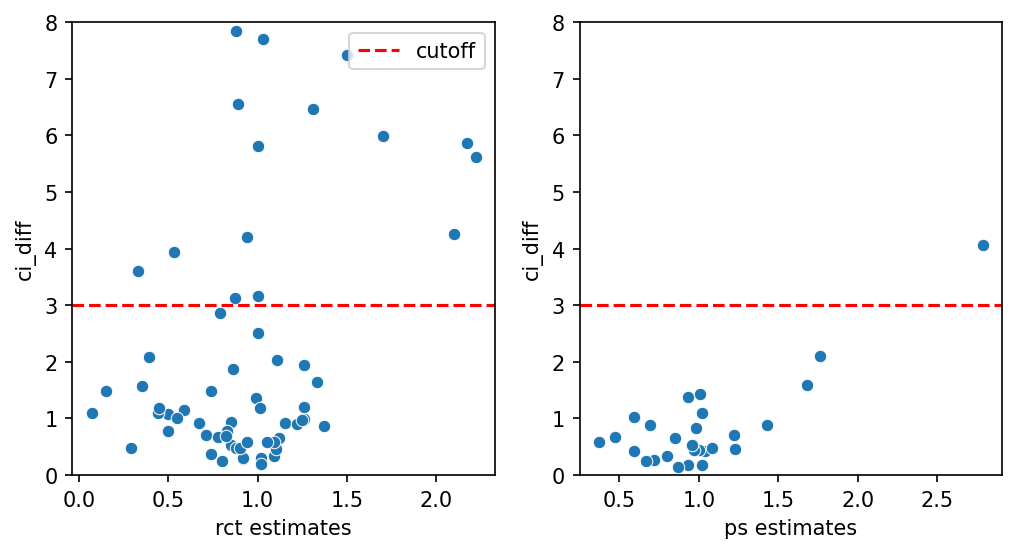

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(8,4))
rct = psm_leak[psm_leak['study_type'] == 'RCT']
ps = psm_leak[psm_leak['study_type'] == 'PS']

sns.scatterplot(data=rct, x='estimate', y='ci_diff', ax=ax1)
ax1.set_ylim(0, 8)
ax1.set_xlabel("rct estimates")
ax1.axhline(y=3, ls='--', color='red', label='cutoff')
ax1.legend()

sns.scatterplot(data=ps, x='estimate', y='ci_diff', ax=ax2)
ax2.set_ylim(0, 8)
ax2.axhline(y=3, ls='--', color='red', label='cutoff')
ax2.set_xlabel("ps estimates")


In [12]:
rct[rct['ci_diff'] > 3]

,study_id,study_type,year,clinical_setting,estimate,lower_ci,upper_ci,ci_diff
9,9,RCT,1993,hyperoncotic starches vs crystalloids (ICU),0.94,0.20,4.41,4.21
10,10,RCT,1998,hyperoncotic starches vs crystalloids (ICU),0.53,0.07,4.01,3.94
12,12,RCT,2008,hyperoncotic starches vs crystalloids (ICU),0.87,0.22,3.35,3.13
15,15,RCT,2010,hyperoncotic starches vs crystalloids (ICU),0.88,0.10,7.95,7.85
16,16,RCT,2011,hyperoncotic starches vs crystalloids (ICU),2.22,0.77,6.39,5.62
22,22,RCT,1977,hyperoncotic albumin vs crystalloids (ICU),1.50,0.29,7.71,7.42
23,23,RCT,1990,hyperoncotic albumin vs crystalloids (ICU),1.70,0.45,6.44,5.99
24,24,RCT,2004,hyperoncotic albumin vs crystalloids (ICU),1.31,0.26,6.72,6.46
25,25,RCT,2004,hyperoncotic albumin vs crystalloids (ICU),1.00,0.17,5.98,5.81
28,28,RCT,1997,diuretics in AKI (inhospital),2.10,0.86,5.12,4.26


In [13]:
psm_leak['study_type'].value_counts()

RCT    62
PS     27
Name: study_type, dtype: int64

# Clip studies with large CIs

In [14]:
# comment this out if we don't want to clip by such studies
sel_psm_leak = psm_leak[psm_leak['ci_diff'] < 3]

# Compute pairwise differences

For each PS study within a clinical setting, we pair it with an RCT and compute
both the year difference as well as the point estimate difference.

$$
\text{diff}_{norm} = \frac{\text{eff}_{PS} - \text{eff}_{RCT}}{\text{eff}_{PS} + \text{eff}_{RCT}}
$$

We want to make the comparison:

$$
E[\text{diff}_{norm} | \text{PS first}] \text{ vs. } E[\text{diff}_{norm} | \text{PS second}]
$$

In [68]:
pair_df = pd.DataFrame()
for clinic_set, group in sel_psm_leak.groupby("clinical_setting"):
    ps_df = group[group['study_type'] == 'PS']
    rct_df = group[group['study_type'] == 'RCT']
    for ps_idx, ps in ps_df.iterrows():
        ps_dict = {
            "study_id": [],
            "rct_year": [],
            "ps_year": [],
            "year_diff": [],
            "rct_est": [],
            "ps_est": [],
            "clinical_setting": [],
            'rct_ci_diff': []
        }
        for rct_idx, rct in rct_df.iterrows():
            ps_dict['study_id'].append(ps['study_id'])
            ps_dict['ps_year'].append(ps['year'])
            ps_dict['rct_year'].append(rct['year'])
            ps_dict['year_diff'].append(ps['year'] - rct['year'])
            ps_dict['rct_est'].append(rct['estimate'])
            ps_dict['ps_est'].append(ps['estimate'])
            ps_dict['clinical_setting'].append(ps['clinical_setting'])
            ps_dict['rct_ci_diff'].append(rct['ci_diff'])
        
        df = pd.DataFrame.from_dict(ps_dict)
        pair_df = pair_df.append(df)

In [69]:
pair_df['raw_diff'] = pair_df['ps_est'] - pair_df['rct_est']
pair_df['norm_diff'] = pair_df['raw_diff'] / (pair_df['ps_est'] + pair_df['rct_est'])

In [70]:
pair_df['rct_est'] = np.log(pair_df['rct_est'])
pair_df['ps_est'] = np.log(pair_df['ps_est'])

In [71]:
no_zero_pairs = pair_df[pair_df['year_diff'] != 0]

In [72]:
no_zero_pairs['ps_after'] = (no_zero_pairs['year_diff'] > 0).astype(int)

/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
no_zero_pairs

,study_id,rct_year,ps_year,year_diff,rct_est,ps_est,clinical_setting,rct_ci_diff,raw_diff,norm_diff,ps_after
1,0,2005.0,2001.0,-4.0,-0.083382,-0.162519,APC in sepsis (inhospital),0.28,-0.07,-0.039548,0
2,0,2009.0,2001.0,-8.0,0.231112,-0.162519,APC in sepsis (inhospital),0.99,-0.41,-0.194313,0
3,0,2012.0,2001.0,-11.0,0.086178,-0.162519,APC in sepsis (inhospital),0.34,-0.24,-0.123711,0
1,1,2005.0,2001.0,-4.0,-0.083382,-0.223144,APC in sepsis (inhospital),0.28,-0.12,-0.069767,0
2,1,2009.0,2001.0,-8.0,0.231112,-0.223144,APC in sepsis (inhospital),0.99,-0.46,-0.223301,0
...,...,...,...,...,...,...,...,...,...,...,...
1,83,2003.0,2005.0,2.0,-0.061875,0.086178,right heart catheterization vs not,0.58,0.15,0.073892,1
2,83,2006.0,2005.0,-1.0,0.048790,0.086178,right heart catheterization vs not,0.59,0.04,0.018692,0
0,84,2002.0,2006.0,4.0,0.009950,0.048790,right heart catheterization vs not,1.18,0.04,0.019417,1
1,84,2003.0,2006.0,3.0,-0.061875,0.048790,right heart catheterization vs not,0.58,0.11,0.055276,1


In [74]:
# TODO do we group by clinical setting or individual study?
group_col = 'study_id'


@interact(
    group_col = ['study_id', 'clinical_setting']
)
def show_reg(group_col):
    fig, (ax1,ax2) = plt.subplots(1, 2, dpi=150, figsize=(10,4))

    sns.scatterplot(data=no_zero_pairs, x='ps_est', y='rct_est', hue='ps_after', ax=ax1)
    sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax1)
    sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax1)
    ax1.set_title("outlier clipped, individual pairs")

    #grouped = no_zero_pairs.sort_values(by=[group_col, 'rct_ci_diff'], ascending=True).groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].head()
    grouped = no_zero_pairs.groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].mean()
    print(f"{no_zero_pairs.shape[0]} individual pairs")
    print(f"{grouped.shape[0]} grouped pairs")

    sns.scatterplot(data=grouped, x='ps_est', y='rct_est', hue='ps_after', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax2)
    ax2.set_title(f"outlier clipped, grouped by {group_col}")
    ax2.set_xlabel("log PS study effect estimate")
    ax2.set_ylabel("log RCT study effect estimate")

interactive(children=(Dropdown(description='group_col', options=('study_id', 'clinical_setting'), value='study…

In [48]:
no_zero_pairs.head()

,study_id,rct_year,ps_year,year_diff,rct_est,ps_est,clinical_setting,rct_ci_diff,raw_diff,norm_diff,ps_after
0,5,2001,2008,7,-0.162519,-0.328504,APC in sepsis (inhospital),0.94,-0.13,-0.082803,1
1,5,2001,2008,7,-0.223144,-0.328504,APC in sepsis (inhospital),0.25,-0.08,-0.052632,1
2,5,2005,2008,3,-0.083382,-0.328504,APC in sepsis (inhospital),0.28,-0.20,-0.121951,1
3,5,2009,2008,-1,0.231112,-0.328504,APC in sepsis (inhospital),0.99,-0.54,-0.272727,0
4,5,2012,2008,-4,0.086178,-0.328504,APC in sepsis (inhospital),0.34,-0.37,-0.204420,0


# Examine all pairs

We examine the PS-RCT pairs that have positive/negative year differences (studies may be counted multiple times)
in a t-test comparing the mean differences in the point estimates.

In [23]:
no_zero_pairs.groupby('ps_after')[['raw_diff', 'norm_diff']].describe().transpose()

ps_after                 0          1
raw_diff  count  30.000000  43.000000
          mean    0.134667  -0.012558
          std     0.509501   0.297642
          min    -0.670000  -0.530000
          25%    -0.142500  -0.235000
          50%     0.095000   0.010000
          75%     0.365000   0.085000
          max     1.610000   0.970000
norm_diff count  30.000000  43.000000
          mean    0.043968   0.012154
          std     0.257901   0.234555
          min    -0.362162  -0.301775
          25%    -0.092973  -0.138603
          50%     0.046919   0.004926
          75%     0.137779   0.068184
          max     0.842932   0.873874

In [24]:
target_col = 'norm_diff'
pg.ttest(no_zero_pairs[no_zero_pairs['ps_after'] == 1][target_col], 
         no_zero_pairs[no_zero_pairs['ps_after'] == 0][target_col])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.538027,58.643576,two-sided,0.592594,"[-0.15, 0.09]",0.130195,0.277,0.084011


# Look at "closest" RCT before

In [25]:
before_pairs = pair_df[pair_df['year_diff'] > 0]

In [26]:
close_before = before_pairs.sort_values(["study_id", "year_diff"]).groupby("study_id").head(1)
close_before[['raw_diff', 'norm_diff']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
raw_diff,17.0,-0.122353,0.243119,-0.530000,-0.330000,-0.070000,0.020000,0.300000
norm_diff,17.0,-0.062081,0.141521,-0.301775,-0.156118,-0.049645,0.010526,0.230769


# Look at "closest" RCT after

In [27]:
after_pairs = pair_df[pair_df['year_diff'] < 0]

In [28]:
close_after = after_pairs.sort_values(["study_id", "year_diff"], ascending=False).groupby("study_id").head(1)
close_after[['raw_diff', 'norm_diff']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
raw_diff,13.0,0.070000,0.567700,-0.670000,-0.220000,-0.070000,0.220000,1.610000
norm_diff,13.0,0.030867,0.296692,-0.362162,-0.112245,-0.033175,0.108696,0.842932


In [29]:
target_col = 'norm_diff'
pg.ttest(close_after[target_col], close_before[target_col])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.042488,16.171862,two-sided,0.31252,"[-0.1, 0.28]",0.419167,0.522,0.195722


# Plotting

We look at the relationship between the year difference and point estimate 
difference, given the repeated measures of an individual PS study.

,r,dof,pval,CI95%,power
rm_corr,0.254079,16,0.308964,"[-0.24, 0.64]",0.17703


(-11.0, 0.0)

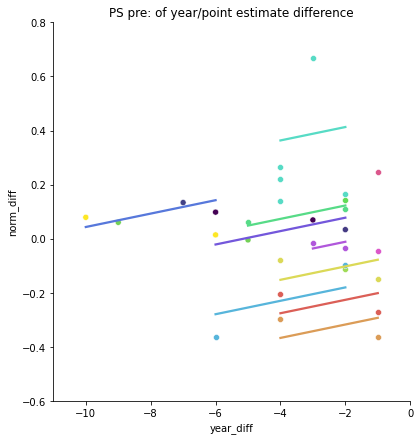

In [30]:
# repeated measures correlation
display(pg.rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='year_diff', y='norm_diff', subject='study_id'))
pg.plot_rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='year_diff', y='norm_diff', subject='study_id',
                kwargs_facetgrid=dict(
                    height=6
                ))
plt.title("PS pre: of year/point estimate difference")
plt.ylim(-0.6, 0.8)
plt.xlim(-11, 0)

,r,dof,pval,CI95%,power
rm_corr,0.224273,25,0.260753,"[-0.17, 0.56]",0.20536


(0.0, 15.0)

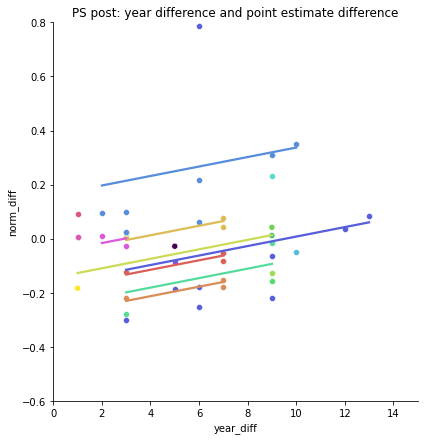

In [31]:
# repeated measures correlation
display(pg.rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='year_diff', y='norm_diff', subject='study_id'))
pg.plot_rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='year_diff', y='norm_diff', subject='study_id',
                kwargs_facetgrid=dict(
                    height=6
                ))
plt.title("PS post: year difference and point estimate difference")
plt.ylim(-0.6, 0.8)
plt.xlim(0, 15)

# Next steps

1. Can dig into the studies and pull out the studies with same year
2. Larger $n=127$ in main text, but some point estimates are aggregated

# Meeting notes

- RCT-RCT agreement is bad, and they overfit to the "best" one
- look at sample size as well